In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import socket
import importlib
import os
import sys

from pointnetvlad_eval_with_scores_arcore import *
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc


In [15]:
QUERY_PATH = 'pointnetvlad_arcore_submaps/'

base_results_path = 'testing_results'
results_path = os.path.join(base_results_path,'pointnetvlad')

if not os.path.exists(base_results_path): os.mkdir(base_results_path)
if not os.path.exists(results_path): os.mkdir(results_path)

partial_results_path = os.path.join(results_path,"partial")
successive_results_path = os.path.join(results_path,"successive")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
if not os.path.exists(successive_results_path): os.mkdir(successive_results_path)
    
results_path, partial_results_path, successive_results_path

('testing_results/pointnetvlad',
 'testing_results/pointnetvlad/partial',
 'testing_results/pointnetvlad/successive')

# Step 3.1.1: One-time partial release case: inference using pointnetvlad

In [16]:
pickle_file = '/arcore_partial_results.pickle'

try:
    with open(partial_results_path + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
        
    print(pickle_file,"exists; last item",results_pickle[-1][0])

except:
    print("No pickle file yet:",pickle_file)
    results_pickle = []
    
for radius in np.arange(0.25,3.1,0.25):
    
    query_fol = 'partial_radius_'+str(radius)
    
    QUERY_FILE = QUERY_PATH+'3d_{}_evaluation_query.pickle'.format(query_fol)
    
    output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'
    
    QUERY_SETS= get_sets_dict(QUERY_FILE)

    query_partial_path = os.path.join(QUERY_PATH,query_fol)

    df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')
    
    QUERY_DATABASE_NUMPY = np.asarray(df_test)
    
    print("Doing",QUERY_FILE,query_partial_path)
    
    ave_recall, ave_intra_dist, test_recall = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)
    
    print(len(test_recall))
    
    results_pickle.append([
            radius,
            ave_recall,
            ave_intra_dist,
            test_recall
    ])

    with open(partial_results_path + pickle_file,'wb') as pickle_output:
        pickle.dump(results_pickle,pickle_output)

    

No pickle file yet: /arcore_partial_results.pickle
Trajectories Loaded.
Doing pointnetvlad_arcore_submaps/3d_partial_radius_0.25_evaluation_query.pickle pointnetvlad_arcore_submaps/partial_radius_0.25
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(1000, 256)
0 0 Database output: (7927, 256) Queries output: (1000, 256)
1 0 Database output: (9439, 256) Queries output: (1000, 256)
 Average Inter-space Error: 0.8594999999999999
 Ave Intra-space Distance Error: 1.1754540435510512
 Average similarity: 0.9762814
2
Trajectories Loaded.
Doing pointnetvlad_arcore_submaps/3d_partial_radius_0.5_evaluation_query.pickle pointnetvlad_arcore_submaps/partial_radius_0.5
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(1000, 256)
0

# Step 3.1.2: Results: One-time release case with pointnetVLAD (vs NN-matcher)

In [21]:
pickle_file = '/arcore_partial_results.pickle'

try:
    with open(partial_results_path + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")

arcore_pv_results = []
arcore_pv_per_space_score = []
arcore_pv_perf_scores = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    arcore_pv_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
    errors_pool = np.asarray(errors_pool)
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    arcore_pv_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    arcore_pv_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
arcore_pv_results = np.asarray(arcore_pv_results)
arcore_pv_per_space_score = np.asarray(arcore_pv_per_space_score)
arcore_pv_perf_scores = np.asarray(arcore_pv_perf_scores)

with open("testing_results/pointnetvlad/arcore_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores],f)


/home/jaybie/.conda/envs/mr-environment/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:

with open("testing_results/pointnetvlad/hololens_summary_results.pickle",'rb') as f:
    [pointnetvlad_hololens, pointnetvlad_per_space_score, pointnetvlad_perf_scores] = pickle.load(f)

with open("testing_results/nn_matcher/hololens_results_partials_nn_matcher.pickle", 'rb') as f:
    [results_partials, raw_errors, ransac_errors] = pickle.load(f)
    
with open("testing_results/nn_matcher/arcore_results_partials_nn_matcher.pickle", 'rb') as f:
    [arcore_results_partials, arcore_errors] = pickle.load(f)
    

"\nplt.savefig('plots/partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')\nplt.savefig('plots/partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')\n"

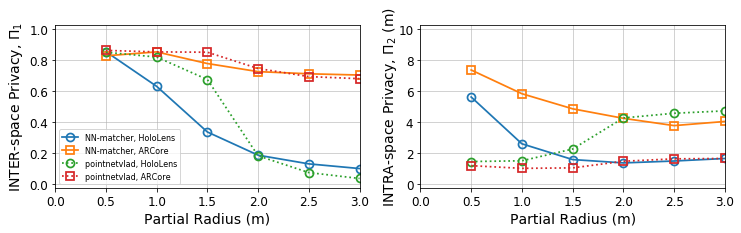

In [27]:
fig=plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Partial Radius (m)", fontsize = 14)

ax1.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax1.set_yticks(np.arange(0,1.1,0.2))
ax1.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

markersize = 8
linewidth = 1.75

RansacNN = np.asarray(results_partials[1])
ARCoreNN = np.asarray(arcore_results_partials)

ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-o",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, HoloLens"
)
ax1.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)

ax1.plot(
    pointnetvlad_hololens[1::2,0],
    pointnetvlad_hololens[1::2,1],
    ":o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, HoloLens"
)

ax1.plot(
    pointnetvlad_arcore[1::2,0],
    pointnetvlad_arcore[1::2,1],
    ":s",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, ARCore"
)

ax1.legend(loc = "lower left", ncol = 1, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14, labelpad = -1.0)
ax2.set_xlabel("Partial Radius (m)", fontsize = 14)

ax2.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax2.set_yticks(np.arange(0,11,2))
ax2.set_yticklabels(np.arange(0,11,2),fontsize=12)

ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-o',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, HoloLens"
)
ax2.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,2],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)
ax2.plot(
    pointnetvlad_hololens[1::2,0],
    pointnetvlad_hololens[1::2,2],
    ":o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, HoloLens"
)

ax2.plot(
    pointnetvlad_arcore[1::2,0],
    pointnetvlad_arcore[1::2,2],
    ":s",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, ARCore"
)

#ax2.legend(loc = "center right", ncol = 1, fontsize = 8);
"""
plt.savefig('plots/partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')
plt.savefig('plots/partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
"""
